<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 05c: Baseline PyTorch Fully Connected Neural Network model test on Main data</h2>
<hr style="color:green" />

<p>
In this file, Train a basic fully connected NN with Pytorch, using a basic 2 layer configuration. This will be the baseline model to experiment with
</p>

In [5]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

Configure this script as to whether it runs on Google Colab, or locally

In [6]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = True

In [7]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [8]:
# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


### Define helper functions

Finding the Mean and Standard Deviations for the training images, in order to do image normalization, is computationally very long. These have been precalculated according to the Train/Validation/Test Split in the images_main.csv file, so create a function here that returns the correct values as tensors.

Create Custom PyTorch Dataset classes for the Binary IsCancerous task and the Multi-class CellType task.

Create a reusable Function to generate an ROC Curve plot(s) that work for both binary classification results and multi-class classification results

In [9]:
# Get the Mean and Standard Deviation for the Training images (precalculated in file 05a)
def getTrainMeanAndStdTensors():
    train_mean = torch.tensor([0.8035, 0.5909, 0.7640])
    train_std = torch.tensor([0.1246, 0.1947, 0.1714])
    return train_mean, train_std

# Custom DataSet class for loading the image dataset using PyTorch NNs for the isCancerous modelling
class CancerBinaryDataset(Dataset):
    def __init__(self, isGoogleColab, dfImages, img_dir, transform=None, target_transform=None): 
        # Store a flag on the deployment env
        self.is_google_colab = isGoogleColab
        # Keep a reference to the data set        
        self.df_images = dfImages
        # Set the labels to the the target column in the dataset
        self.img_labels = dfImages["isCancerous"]
        # Pass in the image directory and transform operation
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Get the length of the dataset from the length of the labels
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # Load the image using the image directory and then from the ImageName col in the dataframe
        img_name = self.df_images.loc[idx, "ImageName"]
        img_name = img_name.replace("\\", "/")

        # if it's google colab, then strip out the leading "./"
        if self.is_google_colab:
            if img_name.startswith("./"):
                img_name = img_name[2:]            

        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)

        # Set the label
        label = self.img_labels[idx]

        # Apply the transform
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Return the image and the label
        return image, label


# Custom DataSet class for loading the image dataset using PyTorch NNs for the CellType modelling
class CancerCellTypeDataset(Dataset):
    def __init__(self, isGoogleColab, dfImages, img_dir, transform=None, target_transform=None): 
        # Store a flag on the deployment env
        self.is_google_colab = isGoogleColab        
        # Keep a reference to the data set
        self.df_images = dfImages
        # Set the labels to the the target column in the dataset
        self.img_labels = dfImages["cellType"]
        # Pass in the image directory and transform operation
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # Get the length of the dataset from the length of the labels
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # Load the image using the image directory and then from the ImageName col in the dataframe
        img_name = self.df_images.loc[idx, "ImageName"]
        img_name = img_name.replace("\\", "/")

        # if it's google colab, then strip out the leading "./"
        if self.is_google_colab:
            if img_name.startswith("./"):
                img_name = img_name[2:]            

        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)

        # Set the label
        label = self.img_labels[idx]

        # Apply the transform
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Return the image and the label
        return image, label    


def getClassificationROC(predictor_name, set_name, y_true, y_pred, num_classes=2, y_pred_scores=None):
    if num_classes <= 1:
        print("Error: Number of label classes must be 2 or more")
        return -1
    elif num_classes == 2:
        # Do a Binary Classification ROC Curve

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1])
        plt.plot(fpr, tpr, label="CNN(area = {:.3f})".format(roc_auc))
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title(predictor_name + " " + set_name + " Set ROC curve")
        plt.legend(loc="best")
        plt.show()

        print("ROC (Area): " + str(roc_auc))
        return roc_auc
    else:
        # Do a multi-class, which will show a ROC Curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        list_roc_auc = []
        
        # first binarize the labels (converting from a number to a list of booleans)        
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        # Loop through each class, Compute ROC curve and ROC area for each class
        for i in range(num_classes):
            # Get a list of the scores for this class
            list_scores = []
            for j in range(len(y_pred_scores)):
                list_scores.append(y_pred_scores[j][i])
                
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], list_scores)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot of a ROC curve for a specific class
        for i in range(num_classes):
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(predictor_name + " " + set_name + " Set ROC for class number " + str(i))
            plt.legend(loc="lower right")
            plt.show()  

            list_roc_auc.append(roc_auc[i])

        # Average the area under curve for each, print and return
        roc_auc_mean = np.mean(list_roc_auc)     
        print("Mean ROC (Area): " + str(roc_auc_mean))     
        return roc_auc_mean



Load the datafile for the main images and split the data into the training/validation/test splits

In [10]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [11]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [12]:
train_mean, train_std = getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [13]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [14]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

Now, create a class for the basic, Fully Connected Neural Network. For this basic NN, we will use 3 fully connected layers. The number of features in this will be 27 x 27 x 3, or 2187.

Layer 1: Input is the images, which are 27 x 27 pixels, with 3 color values (RGB). Experiment initially with 1458 nodes
Layer 2: Input is 1458 from the the previous layer, down to 729
Layer 3: Input is 729 from the the previous layer, since this is a binary classification problem, the output will be 2 classes

In this, we will use the **ReLU** Activation Function. This is the Rectified Linear Unit function, which allows the function to become non-linear

In [15]:
# Create a class for the Neural Network
class PT_NN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_IsCancerous, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 729)
        self.fc2 = nn.Linear(729, 2)
        self.sigmoid = nn.Sigmoid()

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))

        # return the result
        return x


Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

In [16]:
# set the Learning Rate to use
learning_rate = 0.001
epochsToUse = 20

net = PT_NN_IsCancerous()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)


for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(cancerous_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...


Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_train_cancerous = []
y_train_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_cancerous.append(labels[j].item())
        y_train_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_cancerous, y_train_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_train_cancerous, y_train_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_train_cancerous, y_train_pred_cancerous)))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[4548  456]
 [ 507 2326]]

- Accuracy Score: 0.8771213474543831
- Precision Score: 0.8360891445003594
- Recall Score: 0.8210377691493117
- F1 Score: 0.8284951024042743


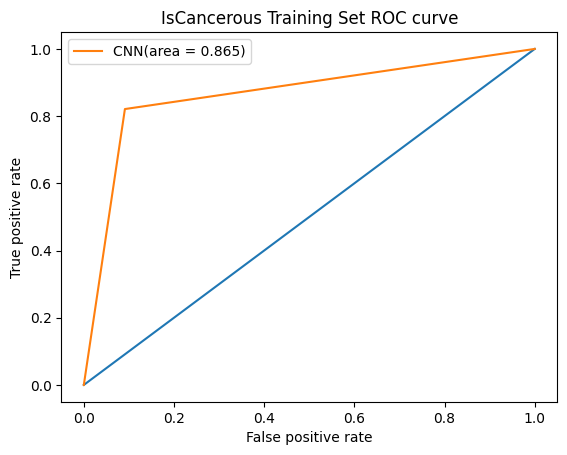

ROC (Area): 0.8649553354139844


0.8649553354139844

In [ ]:
getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict according to the Validation data and evaluate. While looping through here, we will need to get out the Labels from the data loader, because the order of predictions in the batches do not match the order of the original Target values in the dataset (because we turned Shuffle on)

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_val_cancerous = []
y_val_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_val_dataloader, 0):
    inputs, labels = data


    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_val_cancerous.append(labels[j].item())
        y_val_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()



print("Evaluate the Validation Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_val_cancerous, y_val_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_val_cancerous, y_val_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_val_cancerous, y_val_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_val_cancerous, y_val_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_val_cancerous, y_val_pred_cancerous)))

Evaluate the Validation Predictions and Error: 

Confusion matrix: 

[[351  57]
 [ 86 537]]

- Accuracy Score: 0.8612997090203686
- Precision Score: 0.9040404040404041
- Recall Score: 0.8619582664526485
- F1 Score: 0.8824979457682828


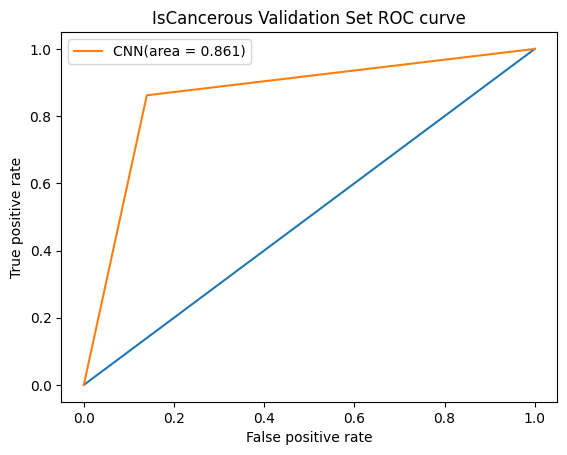

ROC (Area): 0.8611261920498537


0.8611261920498537

In [ ]:
getClassificationROC("IsCancerous", "Validation", y_val_cancerous, y_val_pred_cancerous, 2)

Now Predict and evaluate on the test Set

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_test_cancerous = []
y_test_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_test_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_cancerous.append(labels[j].item())
        y_test_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_cancerous, y_test_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_test_cancerous, y_test_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_test_cancerous, y_test_pred_cancerous)))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[347  58]
 [ 75 548]]

- Accuracy Score: 0.8706225680933852
- Precision Score: 0.9042904290429042
- Recall Score: 0.8796147672552167
- F1 Score: 0.8917819365337674


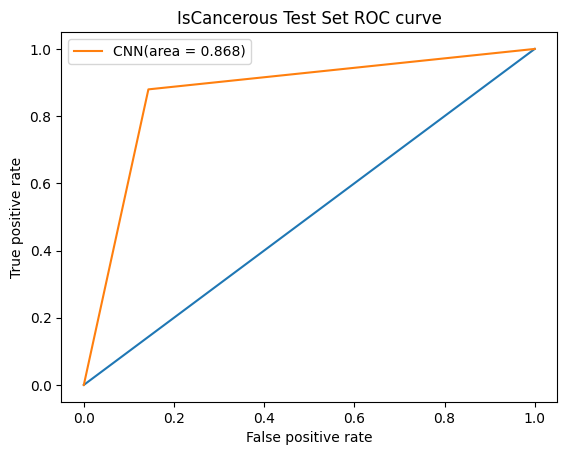

ROC (Area): 0.8682024453560034


0.8682024453560034

In [ ]:
getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

In [ ]:
for i in range(3):
    print(predictions[i])

print(len(predictions))

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
33


In [ ]:
# y_val_pred_cancerous = [item for sublist in y_val_pred_cancerous for item in sublist]
print("Labels")
for i in range(5):
    print(y_val_cancerous[i])

print("Predictions")
for i in range(5):
    print(y_val_pred_cancerous[i])

Labels
1
1
1
0
1
Predictions
1
1
1
0
1


Now also train a model for CellType Predictions

In [ ]:
celltype_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [ ]:
# Create a class for the Neural Network
class PT_NN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_CellType, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 729)
        self.fc2 = nn.Linear(729, 4)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        # return the result
        return x

Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [ ]:
# set the Learning Rate to use
learning_rate = 0.0001
epochsToUse = 20

net = PT_NN_CellType()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

for epoch in range(epochsToUse):
    print("Starting Epoch " + str(epoch) + "...")
    for i, data in enumerate(celltype_train_dataloader, 0):
        # Get the inputs
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Perform Forward and Backward propagation then optimize the weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Starting Epoch 0...
Starting Epoch 1...
Starting Epoch 2...
Starting Epoch 3...
Starting Epoch 4...
Starting Epoch 5...
Starting Epoch 6...
Starting Epoch 7...
Starting Epoch 8...
Starting Epoch 9...
Starting Epoch 10...
Starting Epoch 11...
Starting Epoch 12...
Starting Epoch 13...
Starting Epoch 14...
Starting Epoch 15...
Starting Epoch 16...
Starting Epoch 17...
Starting Epoch 18...
Starting Epoch 19...


Predict on the Training Set to get the Training Accuracy and Error

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_train_celltype = []
y_train_pred_celltype = []
y_train_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_celltype.append(labels[j].item())
        y_train_pred_celltype.append(predicted[j].item())
        y_train_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_celltype, y_train_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_celltype, y_train_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_train_celltype, y_train_pred_celltype, average="micro")))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[  15 1138  437    3]
 [   0 1422  751    0]
 [   0  377 2456    0]
 [   3  845  389    1]]

- Accuracy Score: 0.49687380375143547
- Precision Score: 0.49687380375143547
- Recall Score: 0.49687380375143547
- F1 Score: 0.49687380375143547


In [ ]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[0.1863497793674469, 0.6201930046081543, 0.0993378683924675, 0.09411945939064026]
[0.12030605226755142, 0.3838810324668884, 0.41059377789497375, 0.0852191150188446]
[0.018879735842347145, 0.06202099099755287, 0.9015982151031494, 0.017500966787338257]
[0.13555186986923218, 0.543691873550415, 0.1987147033214569, 0.12204154580831528]
[0.14227265119552612, 0.6062377691268921, 0.09412989765405655, 0.15735967457294464]


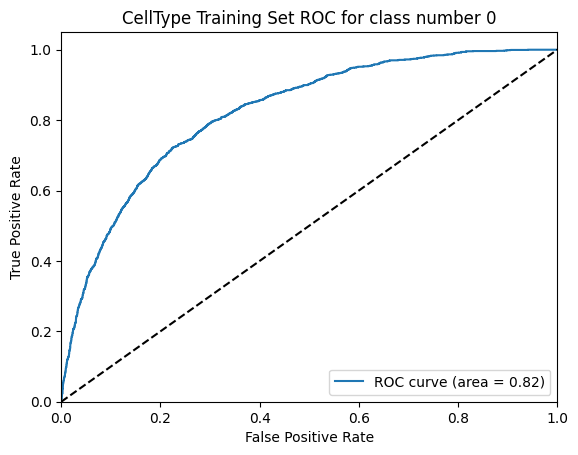

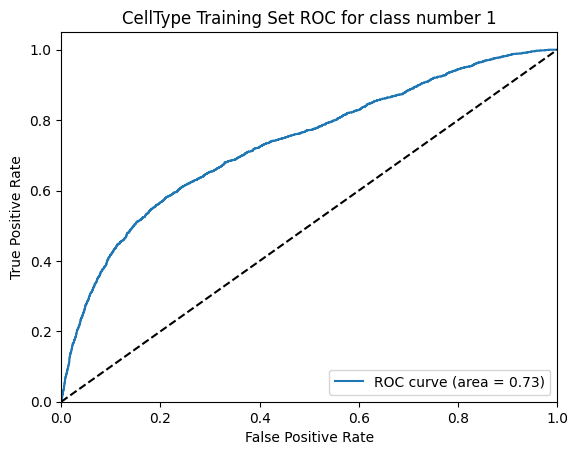

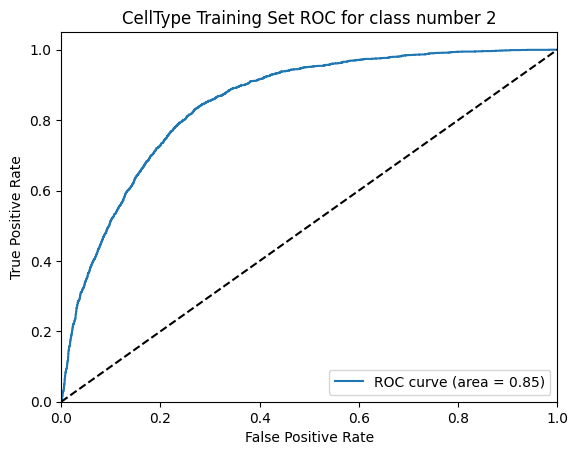

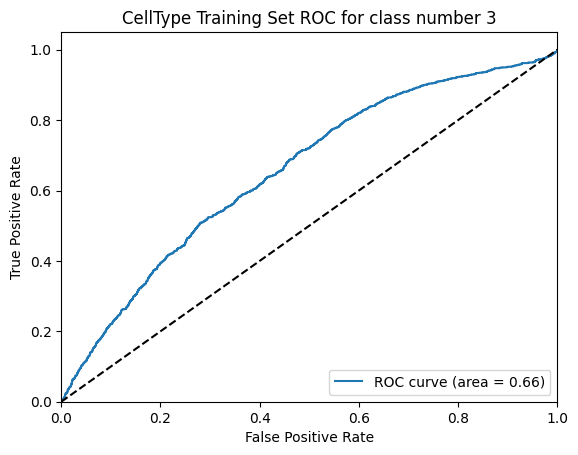

Mean ROC (Area): 0.765399447212446


0.765399447212446

In [ ]:
getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Predict on the Validation data and evaluate the results

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_val_celltype = []
y_val_pred_celltype = []
y_val_pred_celltype_scores = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_val_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_val_celltype.append(labels[j].item())
        y_val_pred_celltype.append(predicted[j].item())
        y_val_pred_celltype_scores.append(outputs.data[j].tolist())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


accuracy = (correct/total) * 100
print("Evaluate the Validation Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_val_celltype, y_val_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_val_celltype, y_val_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_val_celltype, y_val_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_val_celltype, y_val_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_val_celltype, y_val_pred_celltype, average="micro")))

Evaluate the Validation Predictions and Error: 

Confusion matrix: 

[[  1 115  39   0]
 [  0 150  35   0]
 [  0  78 545   0]
 [  0  31  37   0]]

- Accuracy Score: 0.6750727449078564
- Precision Score: 0.6750727449078564
- Recall Score: 0.6750727449078564
- F1 Score: 0.6750727449078564


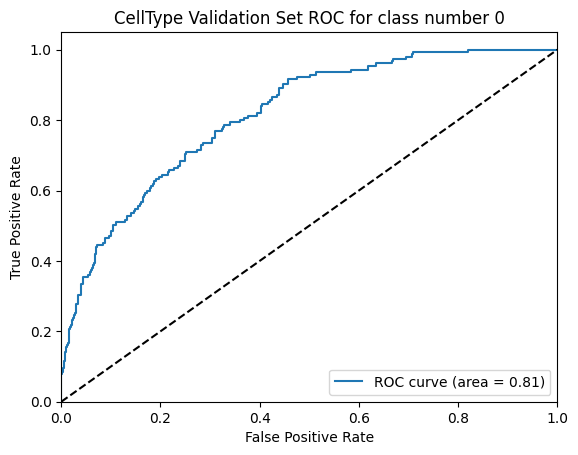

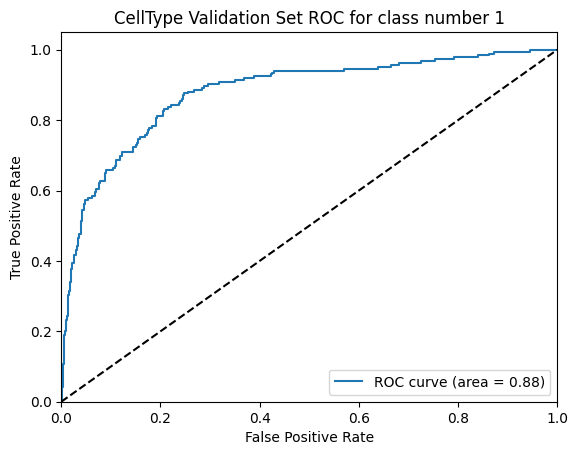

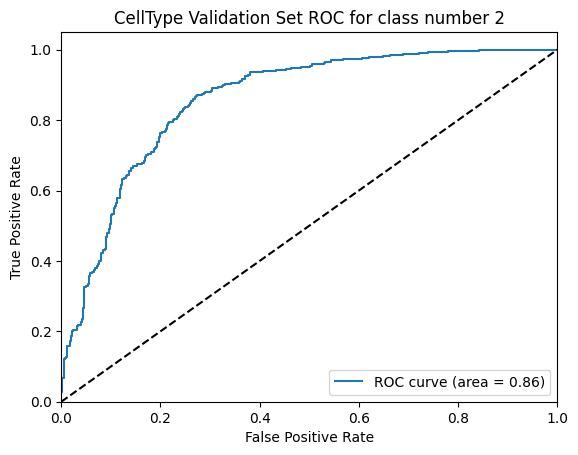

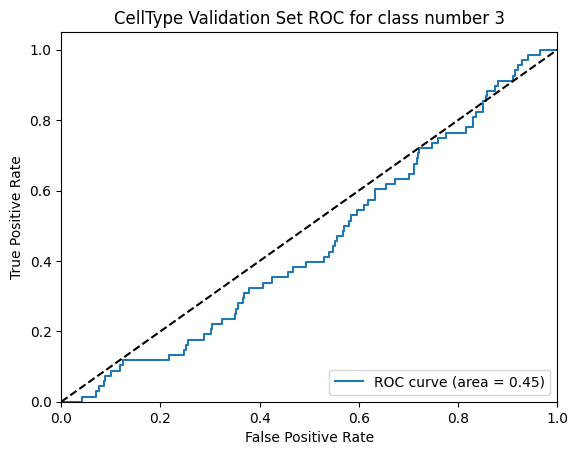

Mean ROC (Area): 0.7500133088735563


0.7500133088735563

In [ ]:
getClassificationROC("CellType", "Validation", y_val_celltype, y_val_pred_celltype, 4, y_val_pred_celltype_scores)

Now Predict and Evaluate on the Test Set

In [ ]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_test_celltype = []
y_test_pred_celltype = []
y_test_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_test_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_celltype.append(labels[j].item())
        y_test_pred_celltype.append(predicted[j].item())
        y_test_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_celltype, y_test_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_celltype, y_test_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_test_celltype, y_test_pred_celltype, average="micro")))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[  1 104  35   0]
 [  0 146  39   0]
 [  0  61 562   0]
 [  0  35  45   0]]

- Accuracy Score: 0.6896887159533074
- Precision Score: 0.6896887159533074
- Recall Score: 0.6896887159533074
- F1 Score: 0.6896887159533074


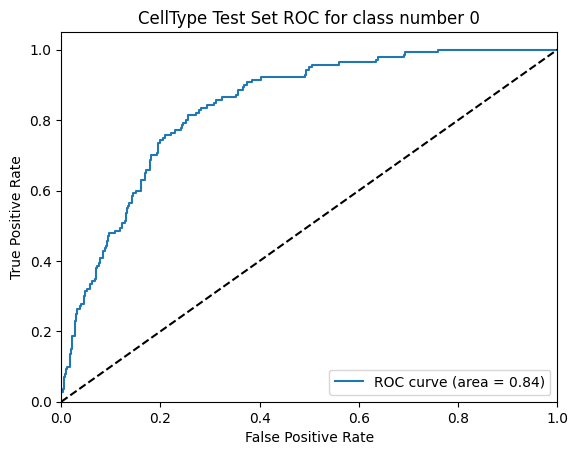

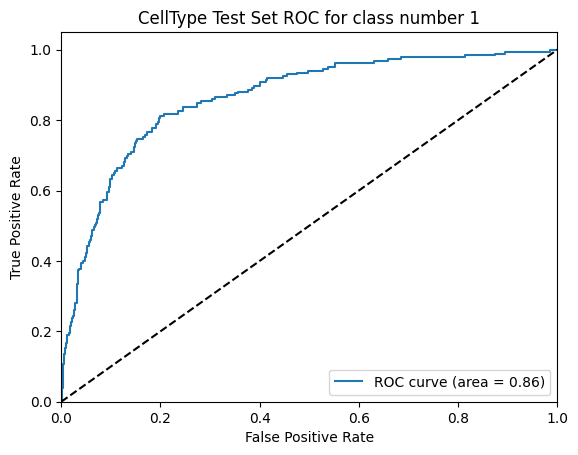

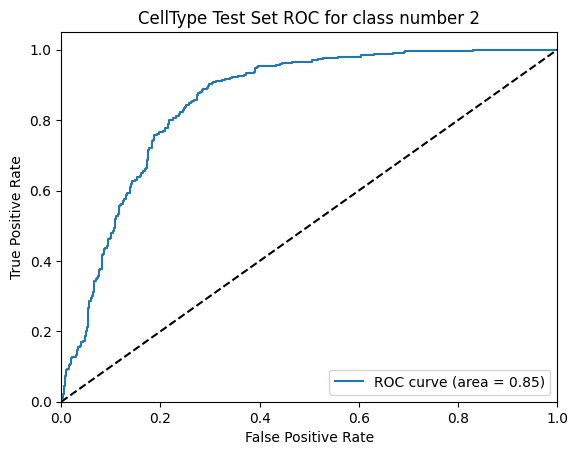

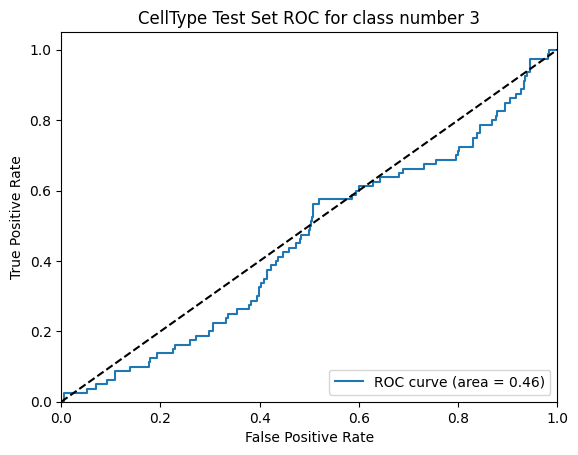

Mean ROC (Area): 0.7533997937796519


0.7533997937796519

In [ ]:
getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

### IsCancerous Results

Baseline, 2 Layer - SGD optimiser
- **Training**
- Accuracy Score: 0.8771213474543831
- Precision Score: 0.8360891445003594
- Recall Score: 0.8210377691493117
- F1 Score: 0.8284951024042743
- **Test**
- Accuracy Score: 0.8706225680933852
- Precision Score: 0.9042904290429042
- Recall Score: 0.8796147672552167
- F1 Score: 0.8917819365337674


Baseline, 2 Layer - Adam optimiser
- **Training**
- Accuracy Score: 0.8739088263821533
- Precision Score: 0.9008130081300812
- Recall Score: 0.8892455858747994
- F1 Score: 0.8949919224555736
- **Test**
- Accuracy Score: 0.8754863813229572
- Precision Score: 0.8985507246376812
- Recall Score: 0.8956661316211878
- F1 Score: 0.8971061093247588


### CellType Results

Baseline, 2 Layer - SGD optimiser
- **Training**
- Accuracy Score: 0.6679851984177619
- Precision Score: 0.6679851984177619
- Recall Score: 0.6679851984177619
- F1 Score: 0.6679851984177619
- **Test**
- Accuracy Score: 0.7636186770428015
- Precision Score: 0.7636186770428015
- Recall Score: 0.7636186770428015
- F1 Score: 0.7636186770428015

Baseline, 2 Layer - Adam optimiser
- **Training**
- Accuracy Score: 0.8720173535791758
- Precision Score: 0.8720173535791758
- Recall Score: 0.8720173535791758
- F1 Score: 0.8720173535791758
- **Test**
- Accuracy Score: 0.7733463035019456
- Precision Score: 0.7733463035019456
- Recall Score: 0.7733463035019456
- F1 Score: 0.7733463035019456